## A6: Neural Networks

## <font color=blue>Import needed modules</font>

In [1]:
#see that Tensorflow is installed
!pip install tensorflow -q

In [2]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TensorFlow requirements
import tensorflow as tf
from tensorflow import keras

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler,PowerTransformer, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import set_config

## <font color=blue>Function Definitions

In [3]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [4]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [5]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

## <font color=blue>Source Data

In [6]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"

filename = "CarData.csv"
downloadDataResource(filename, path)
car = pd.read_csv(filename)

Data resource CarData.csv already downloaded.


In [70]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"

filename = "CarPredictions.csv"
downloadDataResource(filename, path)
carpred = pd.read_csv(filename)

Data resource CarPredictions.csv already downloaded.


## <font color=blue>Explore the data set

In [68]:
car.shape

(11891, 13)

In [71]:
carpred.shape

(3, 15)

In [8]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Model              11891 non-null  object 
 2   Year               11891 non-null  int64  
 3   Engine Fuel Type   11891 non-null  object 
 4   Engine HP          11822 non-null  float64
 5   Engine Cylinders   11861 non-null  float64
 6   Transmission Type  11891 non-null  object 
 7   Driven_Wheels      11891 non-null  object 
 8   Number of Doors    11885 non-null  float64
 9   Market Category    8151 non-null   object 
 10  Vehicle Size       11891 non-null  object 
 11  Vehicle Style      11891 non-null  object 
 12  highway MPG        11891 non-null  int64  
 13  city mpg           11891 non-null  int64  
 14  Popularity         11891 non-null  int64  
 15  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5

In [10]:
carpred["Vehicle Size"][0:5]

0    Compact
1    Midsize
2    Compact
Name: Vehicle Size, dtype: object

In [11]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Model              11891 non-null  object 
 2   Year               11891 non-null  int64  
 3   Engine Fuel Type   11891 non-null  object 
 4   Engine HP          11822 non-null  float64
 5   Engine Cylinders   11861 non-null  float64
 6   Transmission Type  11891 non-null  object 
 7   Driven_Wheels      11891 non-null  object 
 8   Number of Doors    11885 non-null  float64
 9   Market Category    8151 non-null   object 
 10  Vehicle Size       11891 non-null  object 
 11  Vehicle Style      11891 non-null  object 
 12  highway MPG        11891 non-null  int64  
 13  city mpg           11891 non-null  int64  
 14  Popularity         11891 non-null  int64  
 15  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5

In [12]:
car["Engine HP"] = car["Engine HP"].fillna(car["Engine HP"].median())

In [13]:
car["Engine Cylinders"] = car["Engine Cylinders"].fillna(car["Engine Cylinders"].median())

In [14]:
car["Number of Doors"] = car["Number of Doors"].fillna(car["Number of Doors"].mean())

In [15]:
car.drop("Model",  inplace=True, axis=1)
car.drop("Market Category",  inplace=True, axis=1)
car.drop("MSRP",  inplace=True, axis=1)

In [16]:
carpred.drop("Model",  inplace=True, axis=1)
carpred.drop("Market Category",  inplace=True, axis=1)

In [17]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Year               11891 non-null  int64  
 2   Engine Fuel Type   11891 non-null  object 
 3   Engine HP          11891 non-null  float64
 4   Engine Cylinders   11891 non-null  float64
 5   Transmission Type  11891 non-null  object 
 6   Driven_Wheels      11891 non-null  object 
 7   Number of Doors    11891 non-null  float64
 8   Vehicle Size       11891 non-null  object 
 9   Vehicle Style      11891 non-null  object 
 10  highway MPG        11891 non-null  int64  
 11  city mpg           11891 non-null  int64  
 12  Popularity         11891 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 1.2+ MB


In [18]:
carpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Make               3 non-null      object
 1   Year               3 non-null      int64 
 2   Engine Fuel Type   3 non-null      object
 3   Engine HP          3 non-null      int64 
 4   Engine Cylinders   3 non-null      int64 
 5   Transmission Type  3 non-null      object
 6   Driven_Wheels      3 non-null      object
 7   Number of Doors    3 non-null      int64 
 8   Vehicle Size       3 non-null      object
 9   Vehicle Style      3 non-null      object
 10  highway MPG        3 non-null      int64 
 11  city mpg           3 non-null      int64 
 12  Popularity         3 non-null      int64 
dtypes: int64(7), object(6)
memory usage: 440.0+ bytes


<AxesSubplot:>

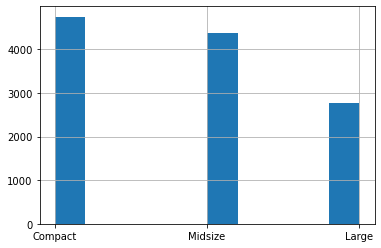

In [19]:
#for regression analysis, we will use the total_earnings attribute
car["Vehicle Size"].hist()

### Build the Neural Network, Compile & Train

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 2, mode="min")

In [82]:
carpred["Vehicle Size"].head()

0    Compact
1    Midsize
2    Compact
Name: Vehicle Size, dtype: object

In [81]:
ord_enc = OrdinalEncoder()
car["Vehicle Size"] = ord_enc.fit_transform(car[["Vehicle Size"]])

## <hr size=10><font color=Blue>Multiclass Classification Neural Network

### Split data set

## Create Train and Test Set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    car.drop(columns=["Vehicle Size"]), 
    car["Vehicle Size"], 
    test_size=.2, 
    random_state=32,
    #stratify = car["Vehicle Size"]
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9512, 12), (9512,), (2379, 12), (2379,))

In [25]:
#look at the first 5 games in the Test data set (will predict later on)
print(X_test[0:5])
print(y_test[0:5])

                Make  Year                Engine Fuel Type  Engine HP  \
6116        Infiniti  2015  premium unleaded (recommended)      328.0   
1884       Chevrolet  2004                regular unleaded      140.0   
7562   Mercedes-Benz  1993                regular unleaded      130.0   
548             Audi  2017  premium unleaded (recommended)      200.0   
10948     Volkswagen  2015  premium unleaded (recommended)      210.0   

       Engine Cylinders Transmission Type      Driven_Wheels  Number of Doors  \
6116                6.0         AUTOMATIC    all wheel drive              4.0   
1884                4.0            MANUAL  front wheel drive              2.0   
7562                4.0            MANUAL   rear wheel drive              4.0   
548                 4.0         AUTOMATIC    all wheel drive              4.0   
10948               4.0            MANUAL  front wheel drive              2.0   

      Vehicle Style  highway MPG  city mpg  Popularity  
6116          Sed

<AxesSubplot:>

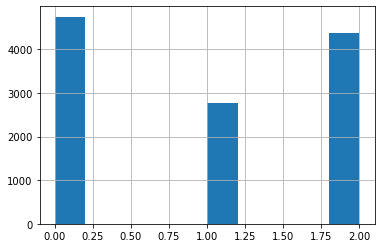

In [26]:
#for regression analysis, we will use the total_earnings attribute
car["Vehicle Size"].hist()

In [27]:
#no categorical attributes for this data set (nice to have in case data changes)
cat_attribs = ["Make", "Year", "Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Style"]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs))

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled using MinMaxScaler (preferred for neural networks)
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), 
 ('std_scaler', MinMaxScaler()),   
])

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

### Prepare the data

In [28]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((9512, 115), (2379, 115))

In [30]:
set_config(display='diagram')

In [31]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  MinMaxScaler())]),
                                 ['Engine HP', 'Engine Cylinders',
                                  'Number of Doors', 'highway MPG', 'city mpg',
                                  'Popularity']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['Make', 'Year', 'Engine Fuel Type',
                                  'Transmission Type', 'Driven_Wheels',
                                  'Vehicle Style'])])

## <font color=blue>Try RandomForestClassifier</font>

### Train and Evaluate Model using Training Data

In [32]:
#create the classification model
forest_clf = RandomForestClassifier(n_estimators=50, random_state=50)

#fit the model using the training data set
forest_clf.fit(X_train, y_train)

#compare the predicted to the actuals
acc = forest_clf.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 98.88%


In [33]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")
print(" Accuracy Score: {:.2f}%".format(np.mean(score)*100))

 Accuracy Score: 93.89%


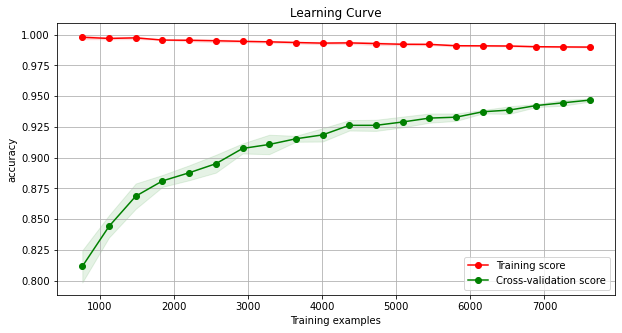

In [34]:
plot_learning_curve(forest_clf, X_train, y_train, scoring='accuracy')

In [37]:
#carpred.drop(columns=[ "Vehicle Size"], inplace = True)
X_prepared = full_pipeline.transform(carpred)
forest_clf.predict(X_prepared[0:3])

array([0., 2., 0.])

### Evaluate Model on Test Set

In [41]:
#see how well the model performs on the test data set
y_pred = forest_clf.predict(X_test)

print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

 Accuracy Score: 95.84%


## <font color=blue>Tune RandomForestClassifier</font>

In [42]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'criterion':['gini', 'entropy'],
     'n_estimators': [10,100,1000],
     'max_features': ["auto","sqrt","log2"]
    }
]

# train across 10 folds, that's a total of (2*3*3)*10=180 rounds of training 
grid_search = GridSearchCV(RandomForestClassifier(random_state=50), param_grid, cv=10,
                           scoring='accuracy',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=50),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [10, 100, 1000]}],
             return_train_score=True, scoring='accuracy')

In [43]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Accuracy: {:,.2f}% - {}".format( mean_score*100, params) )

Accuracy: 94.55% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
Accuracy: 94.94% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
Accuracy: 95.01% - {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}
Accuracy: 94.55% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
Accuracy: 94.94% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 95.01% - {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000}
Accuracy: 94.17% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
Accuracy: 94.83% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
Accuracy: 94.81% - {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000}
Accuracy: 94.30% - {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 10}
Accuracy: 94.90% - {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}
Accuracy: 95.03% - {'criterion': 'entropy', 'max_

In [44]:
#display the best soluiton
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 1000}

### Create the best RandomForestClassifier

In [45]:
#use the parameters found above to create the model
model = RandomForestClassifier(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

#compare the predicted to the actuals
acc = model.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 98.88%


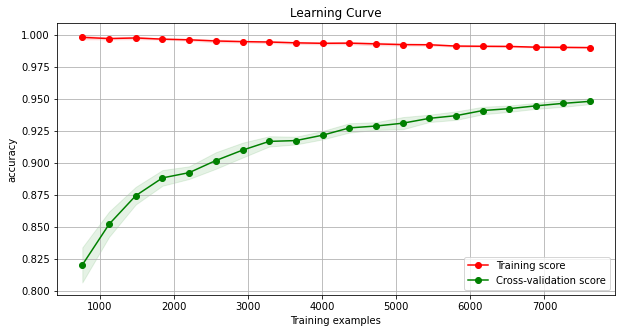

In [46]:
plot_learning_curve(model, X_train, y_train,scoring="accuracy")

### Evaluate best RandomForestClassifier on Test Set

In [47]:
#see how well the model performs on the test data set
y_pred = model.predict(X_test)

print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

 Accuracy Score: 95.96%


In [48]:
X_test.shape

(2379, 115)

In [50]:
#carpred.drop(columns=[ "Vehicle Size"], inplace = True)
X_prepared = full_pipeline.transform(carpred)
model.predict(X_prepared[0:3])

array([0., 2., 0.])

### Build the Neural Network, Compile & Train

In [54]:
early_stopping = keras.callbacks.EarlyStopping(
patience = 2,
mode='min',
monitor='val_loss'
)

In [55]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [56]:
X_test.shape

(2379, 115)

In [57]:
#build a simple model keeping the last layer with activation softmax and 3 to predict games into 1 of 3 classes
model = keras.models.Sequential([
    keras.layers.Flatten(),   #NOTE: Ok to leave out input shape - it will determine when reading X
    keras.layers.Dense(90, activation="relu"),  #60  --> .1448
    #keras.layers.Dense(25, activation="softmax"), #25
    #keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

In [58]:
#After model is created, it needs to be compiled - this requires setting
#the loss function for multi-class (sparse_categorical_crossentropy when Y is all numbers) 
#metric to measure performance is accuracy

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=.001),
              metrics=['accuracy']
             )

In [59]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data will be dynamically allocated as 20% of the training data
history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=.2,
                    callbacks = [early_stopping]
                   )

Epoch 1/500
238/238 [==============================] - 1s 3ms/step - loss: 0.8081 - accuracy: 0.6282 - val_loss: 0.6400 - val_accuracy: 0.7199
Epoch 2/500
238/238 [==============================] - 0s 2ms/step - loss: 0.5833 - accuracy: 0.7395 - val_loss: 0.5520 - val_accuracy: 0.7562
Epoch 3/500
238/238 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.7814 - val_loss: 0.4954 - val_accuracy: 0.7830
Epoch 4/500
238/238 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.8077 - val_loss: 0.4589 - val_accuracy: 0.8061
Epoch 5/500
238/238 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.8307 - val_loss: 0.4332 - val_accuracy: 0.8203
Epoch 6/500
238/238 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8553 - val_loss: 0.3974 - val_accuracy: 0.8445
Epoch 7/500
238/238 [==============================] - 0s 2ms/step - loss: 0.3444 - accuracy: 0.8711 - val_loss: 0.3689 - val_accuracy: 0.8628

### Evaluate Performance

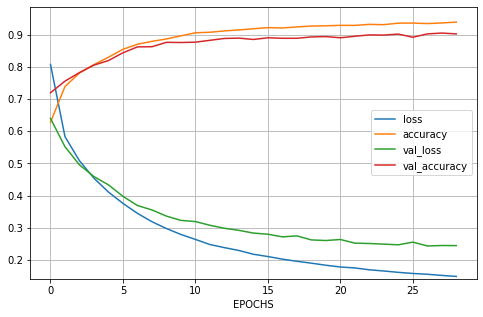

In [60]:
#plot the loss learning curve
nn_plot_learning_curve(history)

In [61]:
#evaluate performance of Training set
accuracy = model.evaluate(X_train, y_train)
print('Loss: {:.2f}  ---  Accuracy: {:.2f}%'.format( accuracy[0], accuracy[1]*100 ) )

298/298 [==============================] - 0s 1ms/step - loss: 0.1564 - accuracy: 0.9384
Loss: 0.16  ---  Accuracy: 93.84%


In [62]:
#evaluate performance of Test set
accuracy = model.evaluate(X_test, y_test)
print('Loss: {:.2f}  ---  Accuracy: {:.2f}%'.format( accuracy[0], accuracy[1]*100 ) )

75/75 [==============================] - 0s 1ms/step - loss: 0.2366 - accuracy: 0.9033
Loss: 0.24  ---  Accuracy: 90.33%


In [66]:
#carpred.drop(columns=[ "Vehicle Size"], inplace = True)
X_prepared = full_pipeline.transform(carpred)
model.predict(X_prepared[0:3])

array([[9.8664397e-01, 6.5093086e-10, 1.3356027e-02],
       [3.4105324e-03, 8.4957668e-05, 9.9650455e-01],
       [9.9772888e-01, 1.1940725e-06, 2.2699747e-03]], dtype=float32)

In [67]:
#see the actual predicted values
np.argmax( model.predict(X_prepared[0:3]) , axis=1)

array([0, 2, 0], dtype=int64)